# Desafío 4 - Proyecto integrador

## Análisis EMSE 2018 - ML para predicción de suicidio adolescente

En este trabajo integrador, vamos a tomar un tema sensible e importante, que en los últimos tiempos se fue agravando y comenzó a cobrar importancia en la sociedad actual: La tendencia creciente mundial de suicidios en adolescentes (entre 11 y 16 años). Debido a esta tendencia la OMS ha puesto como objetivo poder reducir este número para el año 2030 mediante el seguimiento de acciones dadas en cada región.

Nuestro objetivo en este trabajo, es tomando como base a la EMSE 2018 (Encuesta Mundial de Salud Escolar), las preguntas realizadas a cada adolescente serán los indicadores (features) para generar modelos estadísticos con el fin de predecir y alarmar si un adolescente tiene intención suicida previo a que se consuma el hecho, de esa forma generar un primer diagnóstico rápido, que de visibilidad y tiempo a un profesional de la salud mental quien definirá los próximos pasos para encarar un tratamiento y mejorar la vida de sus pacientes.


<a id="section_toc"></a> 
## Tabla de Contenidos

<a href="#section_1">Introducción - Importaciones</a>

<a href="#section_2">Agregado de variables exógenas</a>

<a href="#section_3">Features</a>

<a href="#section_4">Evaluación de modelos - Preparación</a>

<a href="#section_5">Feature Selection</a>

<a href="#section_6">Pipeline - Preprocesamiento</a>

<a href="#section_7">Modelos - Regresión Logística</a>

<a href="#section_8">Modelos - Regresión Logística (Umbral)</a>

<a href="#section_9">Modelos - GNB</a>

<a href="#section_10">Modelos - DTree</a>

<a href="#section_11">Modelos - KNN</a>

<a href="#section_12">Modelos - Ensambles 1</a>

<a href="#section_13">Modelos - Bagging</a>

<a href="#section_14">Modelos - Boosting - Adaboost</a>

<a href="#section_15">Modelos - Boosting - GradientBoosting</a>

<a href="#section_16">Modelos - Ensamble 2</a>

<a href="#section_17">Modelos - XGBoost</a>

<a href="#section_18">Modelos - XGBoost (Umbral)</a>

<a href="#section_19">Comparación de modelos</a>

<a href="#section_20">Conclusión y serialización del mejor modelo</a>

---

<a id="section_1"></a> 

### Introducción - Importaciones

[volver a TOC](#section_toc)

In [1]:
# Importación de librerías
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import randint

# preparación de modelos
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn.preprocessing import binarize, LabelEncoder, MinMaxScaler, StandardScaler

# modelos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree

# pipeline
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Librerías de validación
from sklearn import metrics
from sklearn.metrics import accuracy_score, mean_squared_error, precision_recall_curve, roc_auc_score
from sklearn.model_selection import cross_val_score
from scipy.stats import mode
from sklearn.metrics import classification_report

#Busqueda hiperparámetros Search
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.base import BaseEstimator, TransformerMixin

#Bagging / Boosting
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost.sklearn import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Importamos el dataset de la encuesta
data = pd.read_spss('BASE EMSE TOTAL PAIS 2018.sav')
print('Filas:', data.shape[0], 'Columnas:', data.shape[1])

Filas: 56981 Columnas: 191


In [3]:
data.head()

,D_R,site,record,q1,q2,q3,q4,q5,q6,q7,...,qnff3g,qnc2g,qntob2g,qnnotb2g,qnbcanyg,qnc1g,qnpa5g,qnpa7g,qnpe3g,qnpe5g
0,,AG,1.0,13 years old,Female,9 prim/polim 2nd high,NaN,NaN,Rarely,NaN,...,2.0,NaN,1.0,NaN,NaN,NaN,1.0,1.0,2.0,2.0
1,,AG,2.0,13 years old,Female,9 prim/polim 2nd high,NaN,NaN,Never,NaN,...,2.0,NaN,2.0,1.0,NaN,NaN,1.0,2.0,2.0,2.0
2,,AG,3.0,14 years old,Male,11 polim 4th high,1.67,56.0,Never,NaN,...,2.0,NaN,2.0,1.0,NaN,NaN,1.0,2.0,2.0,2.0
3,,AG,4.0,16 years old,Male,9 prim/polim 2nd high,1.73,70.0,Never,NaN,...,1.0,NaN,2.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0
4,,AG,5.0,13 years old,Female,9 prim/polim 2nd high,NaN,NaN,Never,NaN,...,2.0,NaN,NaN,NaN,NaN,NaN,2.0,2.0,2.0,2.0


In [4]:
# Se realiza el drop de las features que no se utilizarán (nos quedamos solo con las preguntas dicotómicas de la encuesta)
data.drop(data.iloc[:, 10:83], inplace = True, axis = 1)

In [5]:
# Se realiza el drop de las features que no se utilizarán (nos quedamos solo con las preguntas dicotómicas de la encuesta)
data.drop(data.iloc[:, 91:117], inplace = True, axis = 1)

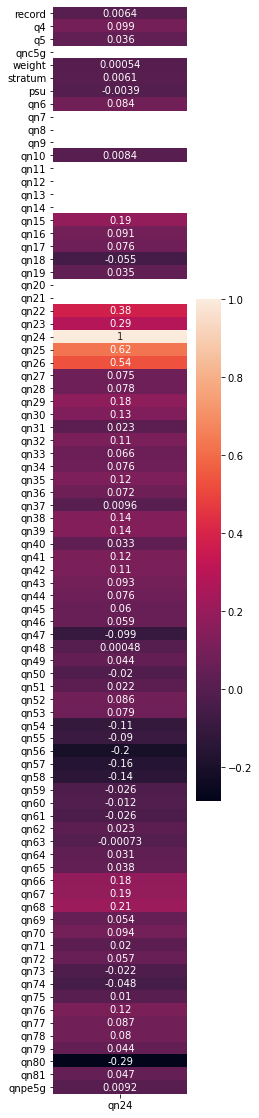

In [6]:
#Observamos la correlación de las columnas Vs el Target antes de hacer Feature Selection.
plt.figure(figsize=(3,20))
sns.heatmap(data.corr()[['qn24']], annot=True);

In [7]:
# En base al heatmap anterior, eliminamos las columnas que poseen muy baja correlación con el target.
# y eliminamos columnas con 100% campos nulos.
data.drop(['qnpe5g','qn74','qn76','qn77','qn78','qn79','qn81','qn62','qn63','qn64','qn65','qn69','qn70','qn72','qn73','qn61','qn58','qn53','qn52','qn51','qn50','qn49','qn46','qn42','qn6','qn37','qn36','qn35','qn34','qn33','qn32','qn30','qn17','qn10','q6','q81','q4','q5','q3','record','site','D_R','q7','qnc5g','qn7','qn8','qn9','qn11','qn12','qn13','qn14','qn18','qn19','qn20','qn21','qn28','qn31','qn40','qn45','qn47','qn48','qn71','qn75'], axis=1, inplace = True)

In [8]:
#Eliminamos los valores nulos de la variable target.
data = data.dropna(subset=['qn24'], axis = 0)

In [9]:
# Observamos la forma del dataset
data.shape

(55628, 29)

In [10]:
#Renombramos la columnas de acuerdo a la pregunta realizada. la columna "suicidio" es la viable target.
data.rename(columns={'qn57':'actividad_chequeo_parental','qn55':'tarea_chequeo_parental','qn44':'encuentro_sexual','qn43':'anfetaminas','qn16':'inicio_pelea','psu':'peso_escuela_densidad','weight':'peso','qn15':'peleas_fisicas','q2':'sexo','q1':'edad','qn80':'padres_no_ridic','qn67':'bullying_NOesc','qn66':'bullying_esc','qn68':'bullying_redes','qn56':'protecc_parental','qn54':'amabilidad','qn41':'marihuana','qn39':'alcohol_conflictos','qn38':'alcohol','qn29':'fumador','qn26':'accion_suicida','qn25':'plan_suicida','qn24':'suicidio','stratum':'escuela','qn22':'soledad','qn23':'preocupacion','qn27':'amigos','qn59':'ne_padre','qn60':'ne_madre'},inplace=True)

In [11]:
# Modificación de los valores de Edad para que queden numéricos
data["edad"] = data["edad"].replace("11 years old or younger", 11).replace("12 years old", 12).replace("13 years old", 13).replace("14 years old", 14).replace("15 years old", 15).replace("16 years old", 16).replace("17 years old", 17).replace("18 years old or older",18)

In [12]:
# Modificación de los valores de Sexo para que quede caracter
data["sexo"] = data["sexo"].replace("Female",1).replace("Male",0)

In [13]:
# Reemplazamos el valor del target suicidio
data["suicidio"] = data["suicidio"].replace(1.0, 1).replace(2.0, 0)

In [14]:
data.sample(5)

,edad,sexo,peso,escuela,peso_escuela_densidad,peleas_fisicas,inicio_pelea,soledad,preocupacion,suicidio,...,amabilidad,tarea_chequeo_parental,protecc_parental,actividad_chequeo_parental,ne_padre,ne_madre,bullying_esc,bullying_NOesc,bullying_redes,padres_no_ridic
8149,17,1,7.8000,201804009.0,17.0,2.0,2.0,2.0,2.0,0.0,...,1.0,2.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0
52969,17,1,6.2080,201823006.0,41.0,2.0,2.0,2.0,2.0,1.0,...,2.0,2.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0
25710,17,0,14.2269,201812003.0,14.0,2.0,2.0,2.0,2.0,1.0,...,2.0,2.0,2.0,1.0,1.0,1.0,2.0,2.0,1.0,2.0
33672,15,0,17.7506,201815006.0,11.0,2.0,1.0,2.0,2.0,1.0,...,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0
3363,15,0,7.1179,201802005.0,10.0,2.0,1.0,2.0,2.0,0.0,...,NaN,NaN,NaN,NaN,1.0,2.0,2.0,2.0,2.0,NaN


In [15]:
#Eliminamos la feature peso.
data.drop(['peso'], axis=1, inplace = True)

In [16]:
# creamos un nuevo Data Set sin valores nulos
data=data.dropna()

In [17]:
#verificación de nulos y Dtype
data.info ()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43032 entries, 6 to 56980
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   edad                        43032 non-null  category
 1   sexo                        43032 non-null  category
 2   escuela                     43032 non-null  float64 
 3   peso_escuela_densidad       43032 non-null  float64 
 4   peleas_fisicas              43032 non-null  float64 
 5   inicio_pelea                43032 non-null  float64 
 6   soledad                     43032 non-null  float64 
 7   preocupacion                43032 non-null  float64 
 8   suicidio                    43032 non-null  float64 
 9   plan_suicida                43032 non-null  float64 
 10  accion_suicida              43032 non-null  float64 
 11  amigos                      43032 non-null  float64 
 12  fumador                     43032 non-null  float64 
 13  alcohol         

In [18]:
# Vemos situación del mismo y al seguir habiendo suficientes valores, continuamos con este
data.shape

(43032, 28)

In [19]:
# vemos desbalanceo del nuevo Data Set
data.suicidio.value_counts (normalize=True)

0.0    0.79176
1.0    0.20824
Name: suicidio, dtype: float64

<AxesSubplot:>

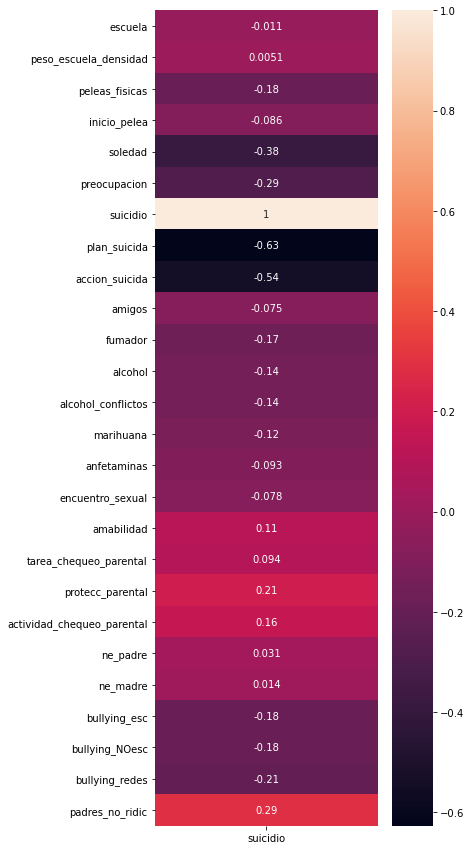

In [20]:
#Observamos la correlación de las columnas Vs el Target
plt.figure(figsize=(5,15))
sns.heatmap(data.corr()[['suicidio']], annot=True)

<a id="section_2"></a>

### Agregado de variables exógenas

[volver a TOC](#section_toc)


En este apartado se incorporan las variables por fuera de la base de datos de la EMSE: 

   La provincia relacionada a la escuela donde asiste el estudiante.
    
   El PBI per capita de esa provincia (medido en millones de dolares estadounidenses dividido la cantidad de la poblacion)
    
   La temperatura media anual de esa provincia

In [21]:
#Merge con base de provincias - Agregado de nombres de provincias por escuela.
provincias = pd.read_csv("provincias.csv")
data_prov = data.merge(provincias, left_on='escuela', right_on='stratum')

In [22]:
#data_prov.drop(['stratum', 'peso','escuela'], axis = 1, inplace = True)
data_prov.drop(['stratum', 'escuela'], axis = 1, inplace = True)


In [23]:
#Agregado del PBI por provincias
pbi_temp_provincias = pd.read_csv("PBI-Prov-temp.csv", sep = ";")
pbi_temp_provincias.head()

,Provincia,PBI (USD),Poblacion,PBIperCapita,pbi_nac,Temp_media
0,Buenos Aires,292689868,15.625.084,18.73,32.3,17.3
1,CABA,"154863803,5",2.891.082,53.56,19.1,17.3
2,Santa Fe,"81588690,27",3.194.537,25.54,8.3,19.1
3,Cordoba,"69363739,19",3.308.876,20.96,7.7,17.9
4,Mendoza,"33431369,11",1.738.929,19.22,3.7,16.3


In [24]:
bin_labels = ['Bajo', 'Medio', 'Alto']
pbi_temp_provincias['PBI_Grupos'] = pd.qcut(pbi_temp_provincias['PBIperCapita'],
                              q=3,
                              labels=bin_labels)
pbi_temp_provincias.sample(5)

,Provincia,PBI (USD),Poblacion,PBIperCapita,pbi_nac,Temp_media,PBI_Grupos
2,Santa Fe,"81588690,27",3.194.537,25.54,8.3,19.1,Alto
22,La Pampa,"6990262,46",316.940,22.05,0.8,15.0,Alto
16,Santiago del Estero,"8387858,73",874.006,9.59,1.1,21.8,Bajo
6,Neuquen,"22564106,16",550.344,41.00,3.1,9.0,Alto
9,Salta,"13438834,91",1.214.441,11.06,2.0,15.9,Bajo


In [25]:
#Merge con base los grupos del PBI por provincia
data_prov_pbi = data_prov.merge(pbi_temp_provincias, left_on='Provincia', right_on='Provincia')

In [26]:
data_prov_pbi.drop(['PBI (USD)', 'Poblacion', 'pbi_nac'], axis = 1, inplace = True)

In [27]:
# creamos un nuevo Data Set sin valores nulos
data_final=data_prov_pbi.dropna()

In [28]:
#Encoding de datos, pasamos de 1 y 2 a binario (0 y 1)
labelDict = {}
for feature in data_final:
    le = preprocessing.LabelEncoder()
    le.fit(data_final[feature])
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    data_final[feature] = le.transform(data_final[feature])
    # Get labels
    labelKey = 'label_' + feature
    labelValue = [*le_name_mapping]
    labelDict[labelKey] =labelValue
    
for key, value in labelDict.items():     
    print(key, value)

label_edad [11, 12, 13, 14, 15, 16, 17, 18]
label_sexo [0, 1]
label_peso_escuela_densidad [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0]
label_peleas_fisicas [1.0, 2.0]
label_inicio_pelea [1.0, 2.0]
label_soledad [1.0, 2.0]
label_preocupacion [1.0, 2.0]
label_suicidio [0.0, 1.0]
label_plan_suicida [1.0, 2.0]
label_accion_suicida [1.0, 2.0]
label_amigos [1.0, 2.0]
label_fumador [1.0, 2.0]
label_alcohol [1.0, 2.0]
label_alcohol_conflictos [1.0, 2.0]
label_marihuana [1.0, 2.0]
label_anfetaminas [1.0, 2.0]
label_encuentro_sexual [1.0, 2.0]
label_amabilidad [1.0, 2.0]
label_tarea_chequeo_parental [1.0, 2.0]
label_protecc_parental [1.0, 2.0]
label_actividad_chequeo_parental [1.0, 2.0]
label_ne_padre [1.0, 2.0]

In [29]:
#Vemos si existe desbalanceo
data_final.suicidio.value_counts(normalize=True)

0    0.79176
1    0.20824
Name: suicidio, dtype: float64

<AxesSubplot:>

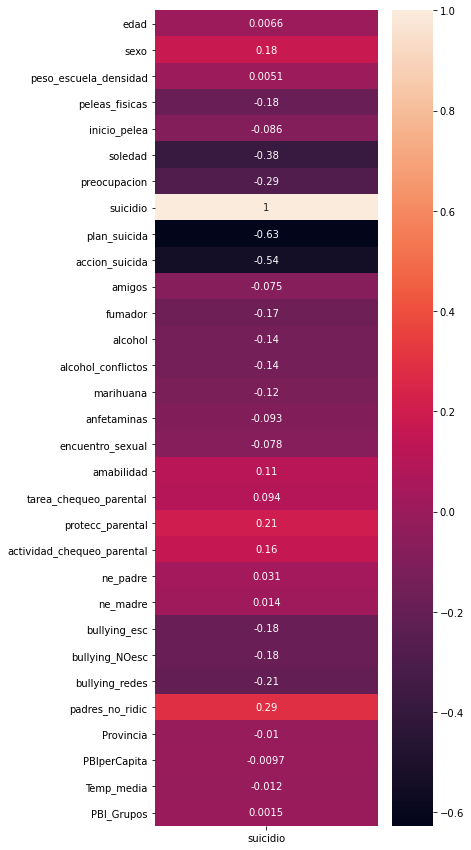

In [30]:
#Observamos la correlación de las columnas Vs el Target
plt.figure(figsize=(5,15))
sns.heatmap(data_final.corr()[['suicidio']], annot=True)

<a id="section_3"></a>

### Descripción de Features

[volver a TOC](#section_toc)


- edad: Los adolescentes encuestados tienen entre 11 y 16 años. Esta columna indica el rango de edad,
- sexo: Corresponde al género: Mujer u Hombre,
- escuela: Es la escuela a la cual concurre el adolescente encuestado,
- peleas_físicas: Estudiantes que participaron de alguna pelea al menos una vez en los últimos 12 meses,
- Inicio_pelea: Estudiantes que iniciaron alguna pelea al menos una vez en los últimos 12 meses,
- soledad: Adolescentes que han tenido sentimientos de soledad en los últimos 12 meses,
- preocupación: Adolescentes que la mayoría del tiempo han estado tan preocupados que no pudieron dormir durante la noche durante los últimos 12 meses,
- **suicidio (TARGET)**: Adolescente que tuvo la intención de suicidarse durante los últimos 12 meses,
- plan_suicida: Adolescente que generó un plan para intentar suicidarse durante los últimos 12 meses,
- accion_suicida: Adolescente que tuvo la acción de suicidarse durante los últimos 12 meses ,
- amigos: estudiantes que no tienen amigos muy cercanos,
- fumador: Adolescente que ha fumado durante los últimos 12 meses,
- alcohol: Adolescente que ha ingerido alcohol durante los últimos 12 meses,
- alcohol_conflictos: Adolescente que tuvo conflictos debido a la ingesta de alcohol durante los últimos 12 meses,
- marihuana: Adolescente que ha fumado marihuana durante los últimos 12 meses,
- anfetaminas: Adolescente que ha consumido anfetaminas durante los últimos 12 meses,
- encuentro_sexual: Adolescente que tuvo algún tipo de encuentro sexual durante los últimos 12 meses,
- amabilidad: Estudiantes cuyos padres o cuidadores siempre o casi siempre comprendieron sus problemas y preocupaciones en los últimos 30 días,
- tarea_chequeo_parental:Estudiantes cuyos padres o cuidadores dan soporte a las tareas escolares siempre o casi siempre en los últimos 30 días,
- protecc_parental: estudiantes cuyos padres o cuidadores sabían realmente lo que hacían en su tiempo libre siempre o casi siempre en los últimos 30 días,
- actividad_chequeo_parental: estudiantes cuyos padres o cuidadores sabían realmente lo que hacían en su tiempo libre siempre o casi siempre en los últimos 30 días,
- bullying_esc: estudiantes que fueron intimidados dentro de la escuela (últimos 12 meses),
- bullying_NOesc: estudiantes que fueron intimidados fuera de la escuela (últimos 12 meses),
- bullying_redes: estudiantes que fueron intimidados por internet (últimos 12 meses),
- padres_no_ridic:  estudiantes cuyos padres o cuidadores nunca o rara vez los hicieron sentir ridículos o los menospreciaron /subestimaron (últimos 12 meses) ,
- Provincia: Provincia en la que se ubica la escuela. En base a esta feature se generó otra utilizando cuantiles (PBI_grupos),
- PBI_grupos: Indica los 3 niveles de PBI de todas las provincias (+ CABA): Bajo, Medio y alto,
- PBIperCapita: PBI provincial dividido la cantidad de habitantes,
- Temp_media: indica la temperatura promedio anual de cada provincia,

<a id="section_4"></a>

### Evaluacion de modelos - Preparación

[volver a TOC](#section_toc)

In [31]:
#Creamos una función para luego poder instanciar todos los modelos y evaluar la perfomance de los mismos
def evalClassModel(model, y_test, y_pred_class, plot=False):
        
    # confusion matrix
    confusion = metrics.confusion_matrix(y_test, y_pred_class)
    
    # guardamos los 4 cuadrantes de la matriz de confusión
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    
    # visualizamos la matriz de confusión
    sns.heatmap(confusion,annot=True,fmt="d") 
    plt.title('Matriz de confusión')
    plt.xlabel('Predichos')
    plt.ylabel('Actual')
    plt.show()
    
    # analizamos accuracy + recall + AUC score --> recordemos que por el problema a solucionar, nosotros buscaremos mejorar el recall
    # manteniendo un accuracy aceptable
    accuracy = round(metrics.accuracy_score(y_test, y_pred_class),3)
    print('Accuracy:', accuracy)
    recall = round(metrics.recall_score(y_test, y_pred_class),3)
    print('Recall =', "Del total de los que realmente tienen tendencia suicida, ¿Cuántas predijo correctamente?")
    print('Recall =', recall)
    
    print('Precision =', "Del total de predichos con tendencia suicida, ¿Cuántos realmente la tienen?")
    print('Precision =', round(metrics.precision_score(y_test, y_pred_class),3))
    
    print('AUC Score:', round(metrics.roc_auc_score(y_test, y_pred_class),3))
    
    # Realizamos un gráfico donde se podrá ver la distribución de las probabilidades predichas para poder ajustar los umbrales
    print("########## ANÁLISIS DE UMBRALES ##########")
    model.predict_proba(X_test)[0:10, 1]
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    
    if plot == True:
        plt.rcParams['font.size'] = 12
        plt.hist(y_pred_prob, bins=8)
        plt.xlim(0,1)
        plt.title('Histograma de probabilidades predichas')
        plt.xlabel('Probabilidad predicha para intención suicida')
        plt.ylabel('Frecuencia')
    
    y_pred_prob = y_pred_prob.reshape(-1,1) 
    y_pred_class = binarize(y_pred_prob, 0.3)[0]
    
    #Gráfico de curva ROC
    roc_auc = metrics.roc_auc_score(y_test, y_pred_prob)
    
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
    if plot == True:
        plt.figure()
        
        plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.rcParams['font.size'] = 12
        plt.title('Curva ROC para clasificación de intención suicida')
        plt.xlabel('False Positive Rate (1 - Specificity)')
        plt.ylabel('True Positive Rate (Sensitivity)')
        plt.legend(loc="lower right")
        plt.show()
    
    def evaluate_threshold(threshold):
        print('Specificity for ' + str(threshold) + ' :', 1 - fpr[thresholds > threshold][-1])
       
    return accuracy, recall

<a id="section_5"></a>

### Análisis de Feature Selection

[volver a TOC](#section_toc)

Filter Method: Select K-best

In [32]:
from sklearn.feature_selection import SelectKBest, f_classif, f_regression

def select_kbest_reg(data_frame, target, k=2):
    feat_selector = SelectKBest(f_classif, k=k)    
    _ = feat_selector.fit(data_frame.drop(target, axis=1), data_frame[target])
    
    feat_scores = pd.DataFrame()
    feat_scores["F Score"] = feat_selector.scores_
    feat_scores["P Value"] = feat_selector.pvalues_
    feat_scores["Support"] = feat_selector.get_support()
    feat_scores["Attribute"] = data_frame.drop(target, axis=1).columns
    
    return feat_scores

kbest_feat = select_kbest_reg(data, "suicidio", k=8)
kbest_feat = kbest_feat.sort_values(["F Score", "P Value"], ascending=[False, False])
kbest_feat

,F Score,P Value,Support,Attribute
8,27817.134482,0.000000e+00,True,plan_suicida
9,17692.251947,0.000000e+00,True,accion_suicida
6,7273.988303,0.000000e+00,True,soledad
26,3956.464268,0.000000e+00,True,padres_no_ridic
7,3822.105853,0.000000e+00,True,preocupacion
25,2016.693075,0.000000e+00,True,bullying_redes
19,1893.303453,0.000000e+00,True,protecc_parental
24,1516.686788,0.000000e+00,True,bullying_NOesc
4,1510.018130,0.000000e+00,False,peleas_fisicas
23,1480.902982,1.443912e-318,False,bullying_esc


Wrapper Method: Eliminación Recursiva de Features (RFE)

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(data.drop('suicidio',axis = 1),data['suicidio'])

scaler = StandardScaler()
    
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

estimator = LinearRegression()
selector = RFE(estimator, n_features_to_select=8, step = 1)
_ = selector.fit(X_train, y_train)

scores = pd.DataFrame()
scores["Attribute Name"] = data.drop('suicidio',axis = 1).columns
scores["Ranking"] = selector.ranking_
scores["Support"] = selector.support_

print(scores)

                Attribute Name  Ranking  Support
0                         edad        6    False
1                         sexo        1     True
2                      escuela       14    False
3        peso_escuela_densidad       13    False
4               peleas_fisicas        2    False
5                 inicio_pelea       17    False
6                      soledad        1     True
7                 preocupacion        1     True
8                 plan_suicida        1     True
9               accion_suicida        1     True
10                      amigos       20    False
11                     fumador        3    False
12                     alcohol       19    False
13          alcohol_conflictos       12    False
14                   marihuana       10    False
15                 anfetaminas       16    False
16            encuentro_sexual       15    False
17                  amabilidad       11    False
18      tarea_chequeo_parental        5    False
19            protec

In [35]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold

In [36]:
kf = KFold(n_splits=5, shuffle = True)
estimator = LinearRegression()
selector = RFECV(estimator, step = 1, cv=kf, scoring = 'neg_mean_squared_error', verbose=2)
selector.fit(X_train, y_train)

Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.


RFECV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
      estimator=LinearRegression(), scoring='neg_mean_squared_error',
      verbose=2)

In [37]:
selector

RFECV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
      estimator=LinearRegression(), scoring='neg_mean_squared_error',
      verbose=2)

In [38]:
data.drop('suicidio', axis=1).loc[:,selector.support_].columns

Index(['edad', 'sexo', 'peleas_fisicas', 'soledad', 'preocupacion',
       'plan_suicida', 'accion_suicida', 'fumador', 'tarea_chequeo_parental',
       'protecc_parental', 'actividad_chequeo_parental', 'ne_madre',
       'bullying_esc', 'bullying_NOesc', 'bullying_redes', 'padres_no_ridic'],
      dtype='object')

<a id="section_6"></a>

### Pipeline - Preprocesamiento

[volver a TOC](#section_toc)

Según los metodos de Feature selection podemos llegar a una conclusión inicial en cuanto a la importancia de las features:

Según Filter methods:
1) plan_suicida;
2) accion_suicida,
3) soledad,
4) padres_no_ridic,
5) preocupacion,
6) bullying_redes,
7) protecc_parental,
8) bullying_NOesc,
9) peleas_fisicas,
10) bullying_esc,

Según Wrapper methods:
9) peleas_fisicas,
3) soledad,
5) preocupacion,
1) plan_suicida,
2) accion_suicida,
7) protecc_parental,
4) padres_no_ridic,
10) bullying_esc,
11) fumador,
6) bullying_redes,

Por lo antes dicho, en el Pipeline vamos a analizar 3 grupos de 10 Features diferentes

In [39]:
# define X and y
X = data_final.drop(["suicidio", "Provincia", "PBI_Grupos", "peso_escuela_densidad"], axis = 1)
y = data_final["suicidio"]

# split X e y  - Stratify Y por desbalanceo
X_train_total, X_test_total, y_train_total, y_test_total = train_test_split(X, y, stratify=y, test_size=0.30, random_state=0)

In [40]:
class FeatureSelection(BaseEstimator, TransformerMixin):
    def __init__(self,selected_features):
        self.selected_features=selected_features

    def fit(self,X,y=None):
        return self
    
    def transform(self, X, y=None):
        return X[self.selected_features]

In [41]:
X_train_total.columns

Index(['edad', 'sexo', 'peleas_fisicas', 'inicio_pelea', 'soledad',
       'preocupacion', 'plan_suicida', 'accion_suicida', 'amigos', 'fumador',
       'alcohol', 'alcohol_conflictos', 'marihuana', 'anfetaminas',
       'encuentro_sexual', 'amabilidad', 'tarea_chequeo_parental',
       'protecc_parental', 'actividad_chequeo_parental', 'ne_padre',
       'ne_madre', 'bullying_esc', 'bullying_NOesc', 'bullying_redes',
       'padres_no_ridic', 'PBIperCapita', 'Temp_media'],
      dtype='object')

In [42]:
# Analizaremos los siguientes grupos de Feautures
union_A1=FeatureSelection(selected_features=['edad', 'sexo', 'plan_suicida', 'accion_suicida', 'soledad', 'padres_no_ridic', 'bullying_esc',
                                             'preocupacion', 'protecc_parental', 'peleas_fisicas' ])
union_A2=FeatureSelection(selected_features=['sexo', 'plan_suicida', 'soledad', 'preocupacion', 'bullying_NOesc', 'bullying_redes',
                                             'PBIperCapita', 'inicio_pelea', 'encuentro_sexual', 'Temp_media'])
union_A3=FeatureSelection(selected_features=['sexo', 'plan_suicida', 'soledad', 'preocupacion', 'actividad_chequeo_parental',
                                             'tarea_chequeo_parental', 'inicio_pelea', 'encuentro_sexual', 'alcohol', 'fumador'])

In [43]:
# Buscaremos ver que estrategia de sampleo es mejor
over = RandomOverSampler(sampling_strategy='minority')
smote = SMOTENC
under = RandomUnderSampler(sampling_strategy='majority')

In [44]:
# Colocamos los pasos del Pipeline
pasos= [('feature_engineeringA',union_A1),
        ('ov', over),
        ('preprocesamiento',StandardScaler()),
        ('clasificador', XGBClassifier(n_jobs=-1, use_label_encoder=False, eval_metric='mlogloss'))]

pipe_grid_final=Pipeline(pasos)

In [45]:
# Evaluaremos en el GridSearch los siguientes parámetros
param_grid_final = [{'feature_engineeringA':[union_A1,union_A2,union_A3],
                    'ov':[over,under,smote],
                    'preprocesamiento':[StandardScaler(), MinMaxScaler(), None]}]

In [46]:
# Realizamos GridSearch con Cross Validation
folds = StratifiedKFold(n_splits=5, random_state=41, shuffle=True)
grid_dos=GridSearchCV(pipe_grid_final, param_grid_final, cv=folds)

In [47]:
grid_dos.fit(X_train_total,y_train_total)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=41, shuffle=True),
             estimator=Pipeline(steps=[('feature_engineeringA',
                                        FeatureSelection(selected_features=['edad',
                                                                            'sexo',
                                                                            'plan_suicida',
                                                                            'accion_suicida',
                                                                            'soledad',
                                                                            'padres_no_ridic',
                                                                            'bullying_esc',
                                                                            'preocupacion',
                                                                            'protecc_parental',
                                            

In [48]:
# Vemos cuales fueron los estimadores elegidos y los utilizaremos para ir analizando el rendimiento de todos los modelos
grid_dos.best_estimator_

Pipeline(steps=[('feature_engineeringA',
                 FeatureSelection(selected_features=['edad', 'sexo',
                                                     'plan_suicida',
                                                     'accion_suicida',
                                                     'soledad',
                                                     'padres_no_ridic',
                                                     'bullying_esc',
                                                     'preocupacion',
                                                     'protecc_parental',
                                                     'peleas_fisicas'])),
                ('ov', RandomOverSampler(sampling_strategy='minority')),
                ('preprocesamiento', MinMaxScaler()),
                ('clasificador',
                 XGBClassifier(base_score...
                               gamma=0, gpu_id=-1, importance_type='gain',
                               interaction_constr

In [49]:
# Por lo visto con el Pipeline, se dividirán los datos de Train y Test con las 10 Features que mejor performaron.
# Luego cuando realicemos el modelo de XGBOOST, utilizaremos la totalidad de las features y veremos nuevamente la importancia de las mismas.

#### Split con TODAS LAS FEATURES Y TODAS LAS FILAS
# X_train_total
# X_test_total
# y_train_total
# y_test_total

#### Split con 10 FEATURES Y TODAS LAS FILAS
X_train_no_esc = X_train_total[['edad', 'sexo', 'plan_suicida', 'accion_suicida', 'soledad', 'padres_no_ridic', 'bullying_esc',
                                'preocupacion', 'protecc_parental', 'peleas_fisicas' ]]
X_test_no_esc = X_test_total[['edad', 'sexo', 'plan_suicida', 'accion_suicida', 'soledad', 'padres_no_ridic', 'bullying_esc',
                                'preocupacion', 'protecc_parental', 'peleas_fisicas' ]]
y_train_no_esc = y_train_total
y_test_no_esc = y_test_total

# Utilizamos StandardScaler
scaler = StandardScaler()
X_train_esc = pd.DataFrame(scaler.fit_transform(X_train_no_esc))
X_test_esc = pd.DataFrame(scaler.transform(X_test_no_esc))
y_train_esc = y_train_no_esc
y_test_esc = y_test_no_esc

# Creamos dos diccionarios para ir guardando los resultados y al final armar un gráfico con Accuracy de todos los modelos y Recall
methodDict = {}
recallDict = {}

In [50]:
print(X_train_esc.shape)
print(X_test_esc.shape)
print(y_train_esc.shape)
print(y_test_esc.shape)

(30122, 10)
(12910, 10)
(30122,)
(12910,)


In [51]:
# Para reducir los tiempos de procesamiento, utilizaremos el hiperparámetro sampling_strategy (estrategia de sampleo)
# La opción 'majority' seleccionará un número de muestras igual al de la clase minoritaria. 
# También se puede pasar un valor numérico entre cero y uno que represente el ratio entre la clase mayoritaria y la minoritaria.

undersampler=RandomUnderSampler(sampling_strategy='majority');

X_train,y_train=undersampler.fit_resample(X_train_esc,y_train_esc);
X_test = X_test_esc
y_test = y_test_esc

print('Composición del training set:')
print(y_train.value_counts())

print('\nComposición del test set:')
print(y_test.value_counts())

Composición del training set:
1    6273
0    6273
Name: suicidio, dtype: int64

Composición del test set:
0    10222
1     2688
Name: suicidio, dtype: int64


In [52]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(12546, 10)
(12910, 10)
(12546,)
(12910,)


<a id="section_7"></a>

### Modelos - Regresión Logística

[volver a TOC](#section_toc)

In [53]:
def logisticRegression():
    # Realizamos una regresión logística y fitteamos. Utilizamos Clases Balanceadas aunque ya sampleamos anteriormente
    logreg = LogisticRegression(class_weight = 'balanced')
    logreg.fit(X_train, y_train)
    
    # Hacemos la predicción para el subset de test
    y_pred_class = logreg.predict(X_test)
    
    print('########### Regresión Logística ###############')
    
    accuracy_score, recall = evalClassModel(logreg, y_test, y_pred_class, True)
    
    #Datos para el Gráfico final
    methodDict['Reg. Log'] = accuracy_score * 100
    recallDict['Reg. Log'] = recall * 100

########### Regresión Logística ###############


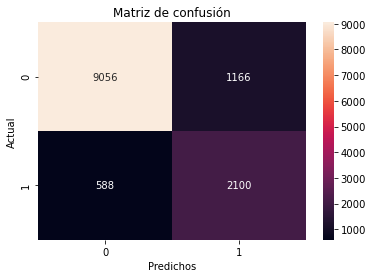

Accuracy: 0.864
Recall = Del total de los que realmente tienen tendencia suicida, ¿Cuántas predijo correctamente?
Recall = 0.781
Precision = Del total de predichos con tendencia suicida, ¿Cuántos realmente la tienen?
Precision = 0.643
AUC Score: 0.834
########## ANÁLISIS DE UMBRALES ##########


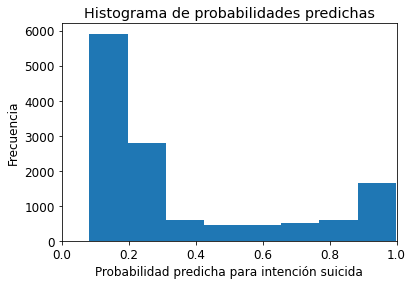

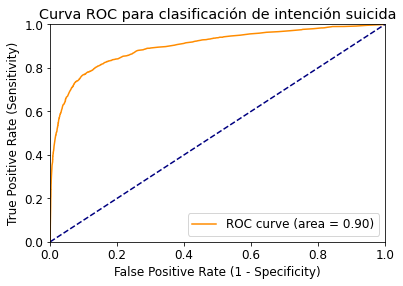

In [54]:
logisticRegression()

<a id="section_8"></a>

### Modelos - Regresión Logística - modificación umbral

[volver a TOC](#section_toc)

In [55]:
logreg = LogisticRegression(class_weight = 'balanced')
logreg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

In [56]:
umbral = 0.25
probs = logreg.predict_proba(X_test)[:,1]
y_pred_test = probs > umbral

########### Logistic Regression - Umbral 25% ###############


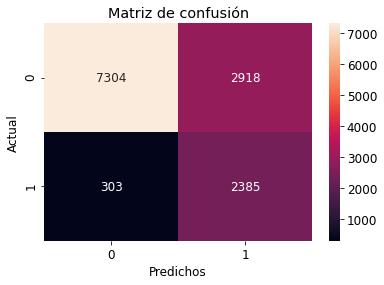

Accuracy: 0.751
Recall = Del total de los que realmente tienen tendencia suicida, ¿Cuántas predijo correctamente?
Recall = 0.887
Precision = Del total de predichos con tendencia suicida, ¿Cuántos realmente la tienen?
Precision = 0.45
AUC Score: 0.801
########## ANÁLISIS DE UMBRALES ##########


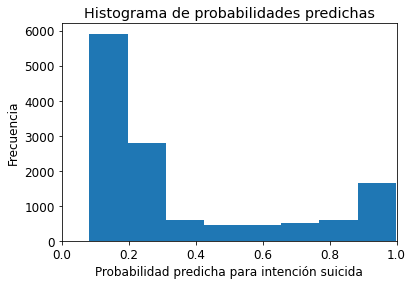

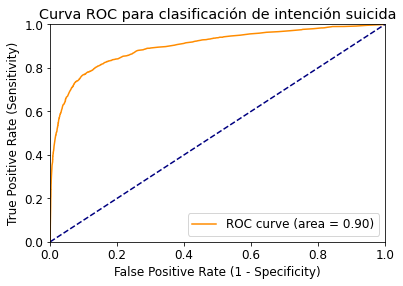

In [57]:
print('########### Logistic Regression - Umbral 25% ###############')
    
accuracy_score, recall = evalClassModel(logreg, y_test, y_pred_test, True)
    
#Datos para el Gráfico final
methodDict['Reg. Log. 25% umbral'] = accuracy_score * 100
recallDict['Reg. Log. 25% umbral'] = recall * 100

<a id="section_9"></a>

### Modelos - GNB

[volver a TOC](#section_toc)

In [58]:
def GNB():
    # entrenamos el modelo naive bayes en el set de train
    GNB_1 = GaussianNB()
    fit_1 = GNB_1.fit(X_train, y_train)
    
    # Predecimos para test
    y_pred_classNB = GNB_1.predict(X_test)
    
    print('########### Gaussian Naive Bayes ###############')
    
    accuracy_score, recall = evalClassModel(GNB_1, y_test, y_pred_classNB, True)
    
    #Datos para el gráfico final
    methodDict['GaussianNB'] = accuracy_score * 100
    recallDict['GaussianNB'] = recall * 100

########### Gaussian Naive Bayes ###############


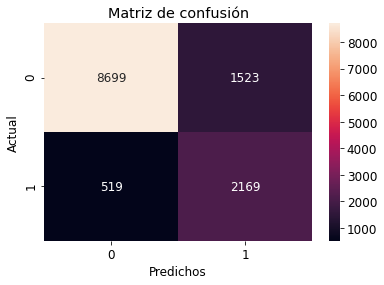

Accuracy: 0.842
Recall = Del total de los que realmente tienen tendencia suicida, ¿Cuántas predijo correctamente?
Recall = 0.807
Precision = Del total de predichos con tendencia suicida, ¿Cuántos realmente la tienen?
Precision = 0.587
AUC Score: 0.829
########## ANÁLISIS DE UMBRALES ##########


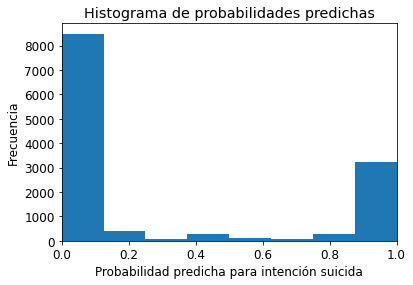

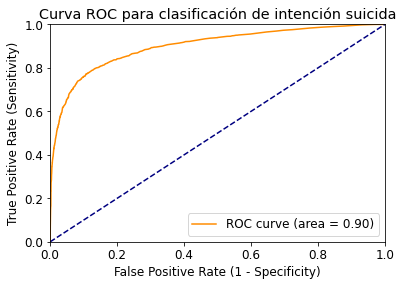

In [59]:
GNB ()
GNB_1 = GaussianNB()
fit_1 = GNB_1.fit(X_train, y_train)

<a id="section_10"></a>

### Modelos - DTree

[volver a TOC](#section_toc)

In [60]:
def DTree():
    # entrenamos el modelo naive bayes en el set de train
    DTree_2 = tree.DecisionTreeClassifier(criterion='gini')
    fit_2 = DTree_2.fit(X_train, y_train)
    
    # Predecimos para test
    y_pred_classDTree = DTree_2.predict(X_test)
    
    print('########### Arbol de decisión ###############')
    
    accuracy_score, recall = evalClassModel(DTree_2, y_test, y_pred_classDTree, True)
    
    #Datos para el gráfico final
    methodDict['Arbol_decision'] = accuracy_score * 100
    recallDict['Arbol_decision'] = recall * 100

########### Arbol de decisión ###############


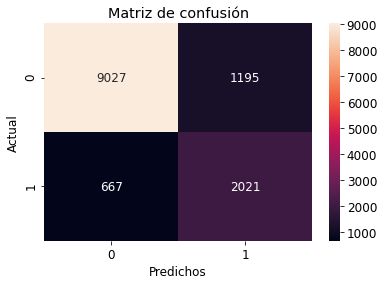

Accuracy: 0.856
Recall = Del total de los que realmente tienen tendencia suicida, ¿Cuántas predijo correctamente?
Recall = 0.752
Precision = Del total de predichos con tendencia suicida, ¿Cuántos realmente la tienen?
Precision = 0.628
AUC Score: 0.817
########## ANÁLISIS DE UMBRALES ##########


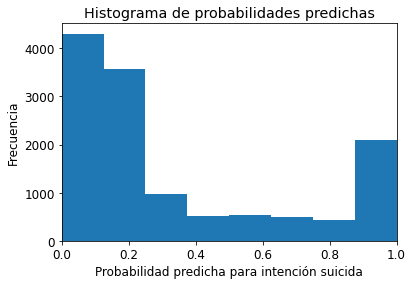

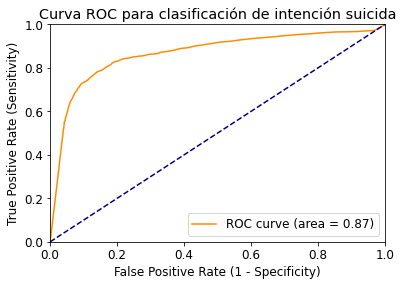

In [61]:
DTree()
DTree_2 = tree.DecisionTreeClassifier(criterion='gini')
fit_2 = DTree_2.fit(X_train, y_train)

<a id="section_11"></a>

### Modelos - KNN

[volver a TOC](#section_toc)

In [62]:
# Se realizó un GridSearch de los 3 hiperparámetros colocando acá el mejor resultado a los efectos de no frenar el proceso
# al momento de que lo corran todo junto. En la búsqueda realizada se intentó optimizar el scoring = "recall"
grid = KNeighborsClassifier(metric='chebyshev', n_neighbors=7, weights='distance')
grid.fit(X_train, y_train)

KNeighborsClassifier(metric='chebyshev', n_neighbors=7, weights='distance')

In [63]:
y_pred_grid = grid.predict(X_test)
y_pred_grid_proba = grid.predict_proba(X_test)

########### KNeighborsClassifier ###############


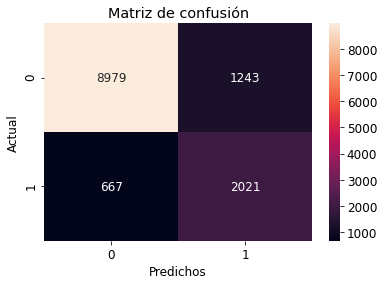

Accuracy: 0.852
Recall = Del total de los que realmente tienen tendencia suicida, ¿Cuántas predijo correctamente?
Recall = 0.752
Precision = Del total de predichos con tendencia suicida, ¿Cuántos realmente la tienen?
Precision = 0.619
AUC Score: 0.815
########## ANÁLISIS DE UMBRALES ##########


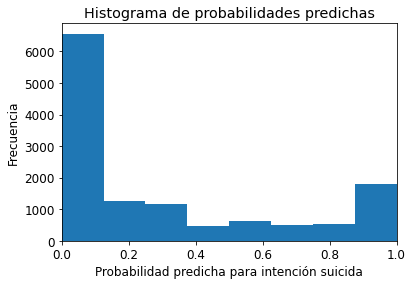

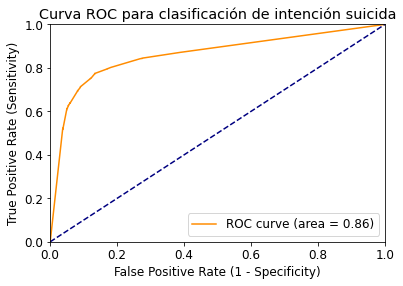

In [64]:
print('########### KNeighborsClassifier ###############')
    
accuracy_score, recall = evalClassModel(grid, y_test, y_pred_grid, True)
#Datos para el gráfico final
methodDict['KNN'] = accuracy_score * 100
recallDict['KNN'] = recall * 100

<a id="section_12"></a>

### Modelos - Ensambles 1

[volver a TOC](#section_toc)

In [65]:
# Utilizaremos los 3 modelos anteriores para realizar un ensamble: un GaussianNB (GNB) un árbol de decisión (DTree) y un KNN
# Generamos el ensamble
def predict_ensamble(X, GNB_1, DTree_2, grid):
    y_pred_classNB = GNB_1.predict(X)
    y_pred_classDTree = DTree_2.predict(X)
    y_pred_classKNN = grid.predict(X)
    result_mode = mode([y_pred_classNB, y_pred_classDTree, y_pred_classKNN]).mode
    result = np.transpose(result_mode)    
    return result

In [66]:
#Hacemos el predict del modelo de ensamble
predict_cat_ensemble = predict_ensamble(X_test, GNB_1, DTree_2, grid)

########### ENSAMBLE 1 ###############


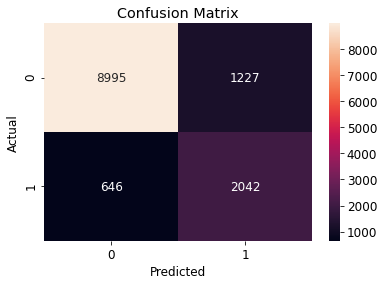

Classification Accuracy: 0.855
Recall = del total de los que realmente tienen tendencia suicida, cuantas las predijo correctamente?
Recall = 0.76
Precision = del total de predichas con tendencia suicida, cuantas reamente la tienen?
Precision = 0.625
AUC Score: 0.82


In [67]:
print('########### ENSAMBLE 1 ###############')
confusion = metrics.confusion_matrix(y_test, predict_cat_ensemble)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
    
sns.heatmap(confusion,annot=True,fmt="d") 
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
    
accuracy = round(metrics.accuracy_score(y_test, predict_cat_ensemble),3)
print('Classification Accuracy:', accuracy)

recall = round(metrics.recall_score(y_test, predict_cat_ensemble),3)
print('Recall =', "del total de los que realmente tienen tendencia suicida, cuantas las predijo correctamente?")
print('Recall =', recall)
    
print('Precision =', "del total de predichas con tendencia suicida, cuantas reamente la tienen?")
print('Precision =', round(metrics.precision_score(y_test, predict_cat_ensemble),3))
print('AUC Score:', round(metrics.roc_auc_score(y_test, predict_cat_ensemble),3))

#Datos para el gráfico final
methodDict['Ensamble 1'] = accuracy * 100
recallDict['Ensamble 1'] = recall * 100

<a id="section_13"></a>

### Modelos - Bagging

[volver a TOC](#section_toc)

In [68]:
def bagging():
    # Construimos base y fitteamos 
    bag = BaggingClassifier(DecisionTreeClassifier(), max_samples=1.0, max_features=1.0, bootstrap_features=False)
    bag.fit(X_train, y_train)
    
    # predecimos con test
    y_pred_class = bag.predict(X_test)
    
    print('########### Bagging ###############')
    
    accuracy_score, recall = evalClassModel(bag, y_test, y_pred_class, True)

    #Datos para el gráfico final
    methodDict['Bagging'] = accuracy_score * 100
    recallDict['Bagging'] = recall * 100

########### Bagging ###############


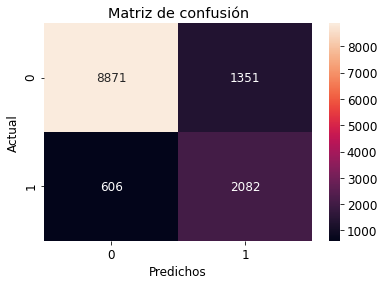

Accuracy: 0.848
Recall = Del total de los que realmente tienen tendencia suicida, ¿Cuántas predijo correctamente?
Recall = 0.775
Precision = Del total de predichos con tendencia suicida, ¿Cuántos realmente la tienen?
Precision = 0.606
AUC Score: 0.821
########## ANÁLISIS DE UMBRALES ##########


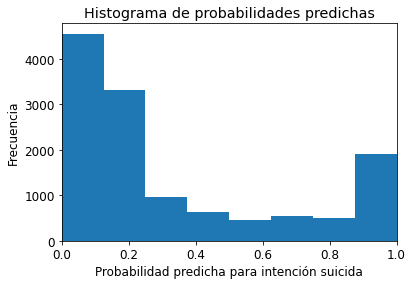

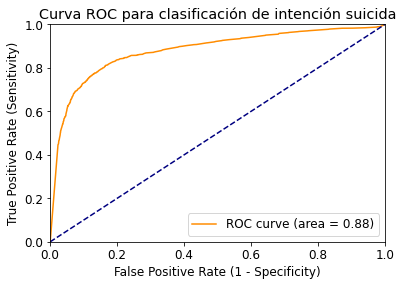

In [69]:
bagging()

<a id="section_14"></a>

### Modelos - Boosting - Adaboost

[volver a TOC](#section_toc)

In [70]:
def boosting():
    # Contruimos y fitteamos 
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=1)
    boost = AdaBoostClassifier(base_estimator=clf, n_estimators=500)
    boost.fit(X_train, y_train)
    
    # predecimos con test
    y_pred_class = boost.predict(X_test)
    
    print('########### AdaBoost ###############')
    
    accuracy_score, recall = evalClassModel(boost, y_test, y_pred_class, True)

    #Datos para el gráfico final
    methodDict['AdaBoost'] = accuracy_score * 100
    recallDict['AdaBoost'] = recall * 100

########### AdaBoost ###############


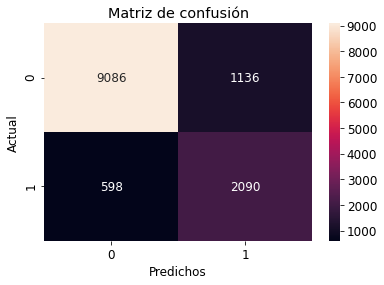

Accuracy: 0.866
Recall = Del total de los que realmente tienen tendencia suicida, ¿Cuántas predijo correctamente?
Recall = 0.778
Precision = Del total de predichos con tendencia suicida, ¿Cuántos realmente la tienen?
Precision = 0.648
AUC Score: 0.833
########## ANÁLISIS DE UMBRALES ##########


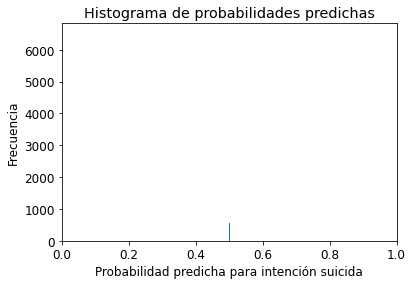

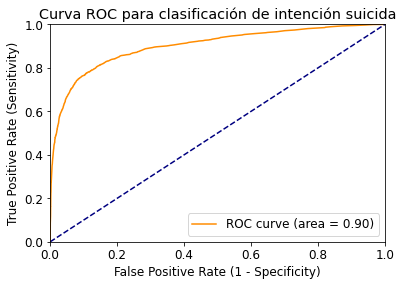

In [71]:
boosting()

<a id="section_15"></a>

### Modelos - Boosting - GradientBoosting

[volver a TOC](#section_toc)

In [72]:
# Realizamos un Gradientboosting con optimización base ya que optimizaremos XGBoost
cv = StratifiedKFold(n_splits=5, random_state=41, shuffle=True)
gb = GradientBoostingClassifier()
params_gb = {'n_estimators':[500, 1000] , 
             'learning_rate':[0.001, 0.1],
            'max_depth' : [2, 3, 4]}

grid_gb = GridSearchCV(gb, param_grid=params_gb, cv=cv, verbose=1, n_jobs=3, scoring='recall')

In [73]:
fit_BOO = grid_gb.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  1.3min
[Parallel(n_jobs=3)]: Done  60 out of  60 | elapsed:  1.9min finished


In [74]:
fit_BOO.best_params_

{'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 500}

########### Gradient Boosting ###############


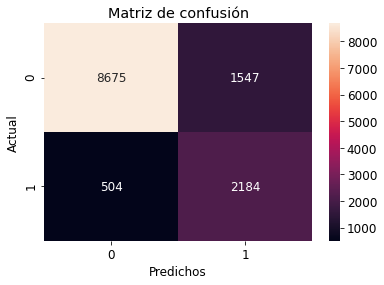

Accuracy: 0.841
Recall = Del total de los que realmente tienen tendencia suicida, ¿Cuántas predijo correctamente?
Recall = 0.812
Precision = Del total de predichos con tendencia suicida, ¿Cuántos realmente la tienen?
Precision = 0.585
AUC Score: 0.831
########## ANÁLISIS DE UMBRALES ##########


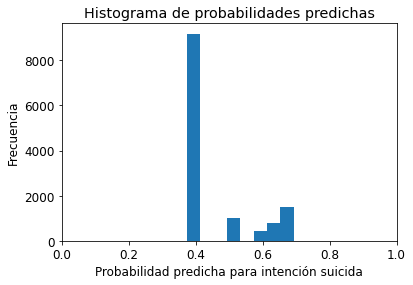

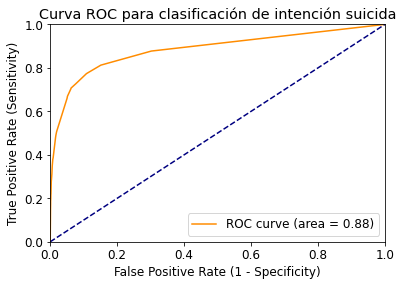

In [75]:
y_pred_class = grid_gb.predict(X_test)

print('########### Gradient Boosting ###############')
    
accuracy_score, recall = evalClassModel(grid_gb, y_test, y_pred_class, True)

#Datos para el gráfico final
methodDict['GadientBoosting'] = accuracy_score * 100
recallDict['GadientBoosting'] = recall * 100

In [76]:
model = grid_gb.best_estimator_
model

GradientBoostingClassifier(learning_rate=0.001, n_estimators=500)

<a id="section_16"></a>

### Modelos - Ensamble 2 - Boosting - Regresión Logística

[volver a TOC](#section_toc)

In [77]:
# Queremos emsamblar regresión logística con umbral modificado y boosting

class LogisticRegressionWithThreshold(LogisticRegression):
    def predict(self, X, threshold=0.1):
        if threshold == None: # Si no pasa, simplemente llamar al umbral 0,5
            return LogisticRegression.predict(self, X)
        else:
            y_scores = LogisticRegression.predict_proba(self, X)[:, 1]
            y_pred_with_threshold = (y_scores >= threshold).astype(int)

            return y_pred_with_threshold
   

In [78]:
lrt = LogisticRegressionWithThreshold()
fit_LR = lrt.fit(X_train, y_train)
y_pred = lrt.predict(X_test)

In [79]:
boost = grid_gb
y_pred_class = boost.predict(X_test)

In [80]:
# Generamos el ensamble
def predict_ensamble(X, boost, lrt):
    y_pred_classBOO = boost.predict(X)
    y_pred_classLR = lrt.predict(X)
    result_mode = mode([y_pred_classBOO, y_pred_classLR]).mode
    result = np.transpose(result_mode)    
    return result

In [81]:
#Hacemos el predict del modelo de ensamble
predict_cat_ensemble = predict_ensamble(X_test, fit_BOO, fit_LR)

########### ENSAMBLE 2 ###############


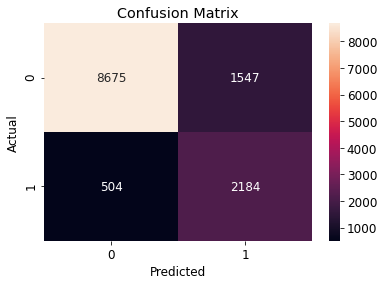

Classification Accuracy: 0.841
Recall = del total de los que realmente tienen tendencia suicida, cuantas las predijo correctamente?
Recall = 0.812
Precision = del total de predichas con tendencia suicida, cuantas reamente la tienen?
Precision = 0.585
AUC Score: 0.831


In [82]:
print('########### ENSAMBLE 2 ###############')
confusion = metrics.confusion_matrix(y_test, predict_cat_ensemble)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
    
sns.heatmap(confusion,annot=True,fmt="d") 
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
    
accuracy = round(metrics.accuracy_score(y_test, predict_cat_ensemble),3)
print('Classification Accuracy:', accuracy)

recall = round(metrics.recall_score(y_test, predict_cat_ensemble),3)
print('Recall =', "del total de los que realmente tienen tendencia suicida, cuantas las predijo correctamente?")
print('Recall =', recall)
    
print('Precision =', "del total de predichas con tendencia suicida, cuantas reamente la tienen?")
print('Precision =', round(metrics.precision_score(y_test, predict_cat_ensemble),3))
print('AUC Score:', round(metrics.roc_auc_score(y_test, predict_cat_ensemble),3))

#Datos para el gráfico final
methodDict['Ensamble 2'] = accuracy * 100
recallDict['Ensamble 2'] = recall * 100

<a id="section_17"></a>

### Modelos - XGBoost

[volver a TOC](#section_toc)

In [83]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(12546, 10)
(12910, 10)
(12546,)
(12910,)


In [84]:
cv = StratifiedKFold(n_splits=5, random_state=41, shuffle=True)

In [85]:
model_xg = XGBClassifier(n_jobs=-1, use_label_encoder=False, eval_metric='mlogloss')

In [86]:
params = {  
    "n_estimators": [50, 100, 200],      # número de estimadores
    "max_depth": [4, 5],           # profundidad
    "scale_pos_weight": [5, 10],  # por desbalanceo  
    "subsample": [0.8, 1, 1.3],        # proporción de submuestras en las instancias de formación (0,5 es al azar)
    "learning_rate": [0.01, 0.1],      # tasa de aprendizaje
}

In [87]:
xgb = GridSearchCV(model_xg, param_grid=params, cv=cv, verbose=1, n_jobs=-1, scoring="recall")

In [88]:
#XGBoost lo fitteamos con todos los datos de Traing (sin subsamplear y sin eliminar feautures)
model_xgb = xgb.fit(X_train_total,y_train_total)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  5.2min finished


In [89]:
xgb.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=10, subsample=0.8, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

########### XGBOOST ###############


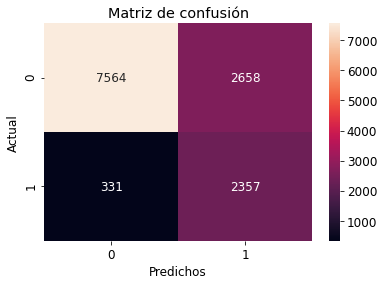

Accuracy: 0.768
Recall = Del total de los que realmente tienen tendencia suicida, ¿Cuántas predijo correctamente?
Recall = 0.877
Precision = Del total de predichos con tendencia suicida, ¿Cuántos realmente la tienen?
Precision = 0.47
AUC Score: 0.808
########## ANÁLISIS DE UMBRALES ##########


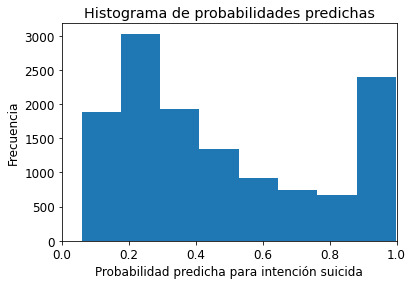

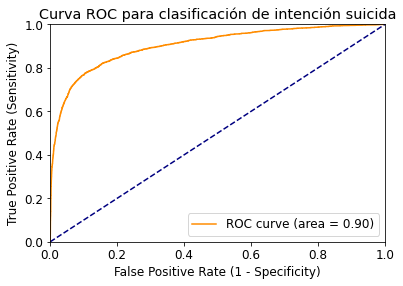

In [90]:
y_pred_class = xgb.predict(X_test_total)

print('########### XGBOOST ###############')

X_test = X_test_total
X_train = X_train_total
accuracy_score, recall = evalClassModel(xgb, y_test_total, y_pred_class, True)

#Datos para el gráfico final
methodDict['XGBOOST'] = accuracy_score * 100
recallDict['XGBOOST'] = recall * 100

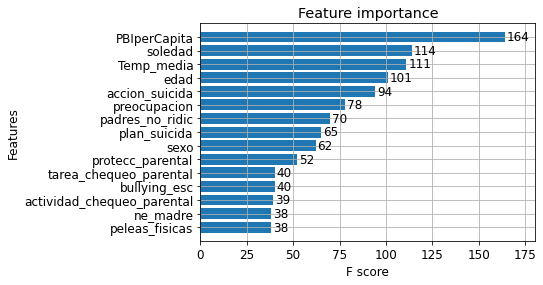

In [91]:
from xgboost import plot_importance
plot_importance(xgb.best_estimator_, height = 0.8, max_num_features=15);

Modelos - XGBoost - analizamos el rendimiento del modelo con las primeras 10 preguntas

In [92]:
X_train_final = X_train_total[['PBIperCapita', 'soledad', 'Temp_media', 'edad', 'accion_suicida', 'padres_no_ridic', 'preocupacion',
                                'plan_suicida', 'protecc_parental', 'sexo', "bullying_esc" ]]
X_test_final = X_test_total[['PBIperCapita', 'soledad', 'Temp_media', 'edad', 'accion_suicida', 'padres_no_ridic', 'preocupacion',
                                'plan_suicida', 'protecc_parental', 'sexo', "bullying_esc" ]]
y_train_final = y_train_total
y_test_final = y_test_total

In [93]:
model_xgb = xgb.fit(X_train_final,y_train_final)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  3.1min finished


########### XGBOOST ###############


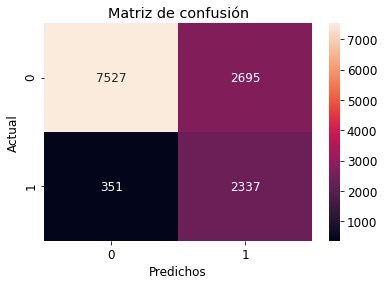

Accuracy: 0.764
Recall = Del total de los que realmente tienen tendencia suicida, ¿Cuántas predijo correctamente?
Recall = 0.869
Precision = Del total de predichos con tendencia suicida, ¿Cuántos realmente la tienen?
Precision = 0.464
AUC Score: 0.803
########## ANÁLISIS DE UMBRALES ##########


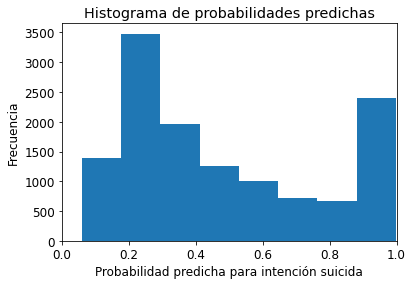

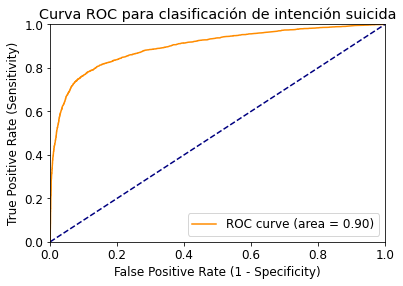

In [94]:
y_pred_class = xgb.predict(X_test_final)

print('########### XGBOOST ###############')

X_test = X_test_final
X_train = X_train_final
accuracy_score, recall = evalClassModel(xgb, y_test_total, y_pred_class, True)

<a id="section_18"></a>

### Modelos - XGBOOST (Umbral)

[volver a TOC](#section_toc)

In [95]:
umbral = 0.43
probs = xgb.predict_proba(X_test)[:,1]
y_pred_class = probs > umbral

########### XGboost umbral + 10 Pregs ###############


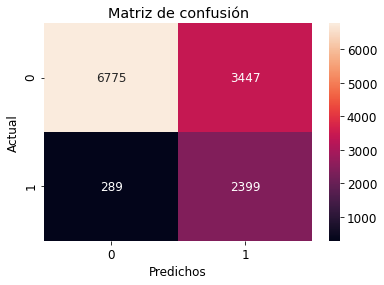

Accuracy: 0.711
Recall = Del total de los que realmente tienen tendencia suicida, ¿Cuántas predijo correctamente?
Recall = 0.892
Precision = Del total de predichos con tendencia suicida, ¿Cuántos realmente la tienen?
Precision = 0.41
AUC Score: 0.778
########## ANÁLISIS DE UMBRALES ##########


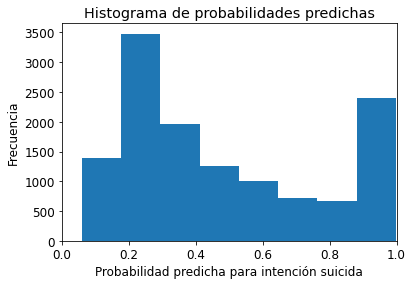

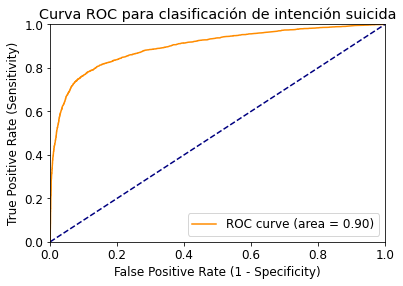

In [96]:
print('########### XGboost umbral + 10 Pregs ###############')
    
accuracy_score, recall = evalClassModel(xgb, y_test, y_pred_class, True)

#Datos para el gráfico final
methodDict['XGboost umbral + 10 Pregs'] = accuracy_score * 100
recallDict['XGboost umbral + 10 Pregs'] = recall * 100

<a id="section_19"></a>

### Comparación de modelos

[volver a TOC](#section_toc)

In [97]:
def plotSuccess1():
    s = pd.Series(recallDict)
    s = s.sort_values(ascending=False)
    plt.figure(figsize=(12,8))
    #Colors
    ax = s.plot(kind='bar') 
    for p in ax.patches:
        ax.annotate(str(round(p.get_height(),2)), (p.get_x() * 1.005, p.get_height() * 1.005))
    plt.ylim([40.0, 95.0])
    plt.xlabel('Modelos')
    plt.ylabel('Recall')
    plt.title('COMPARACIÓN MODELOS SEGUN RECALL')
     
    plt.show()

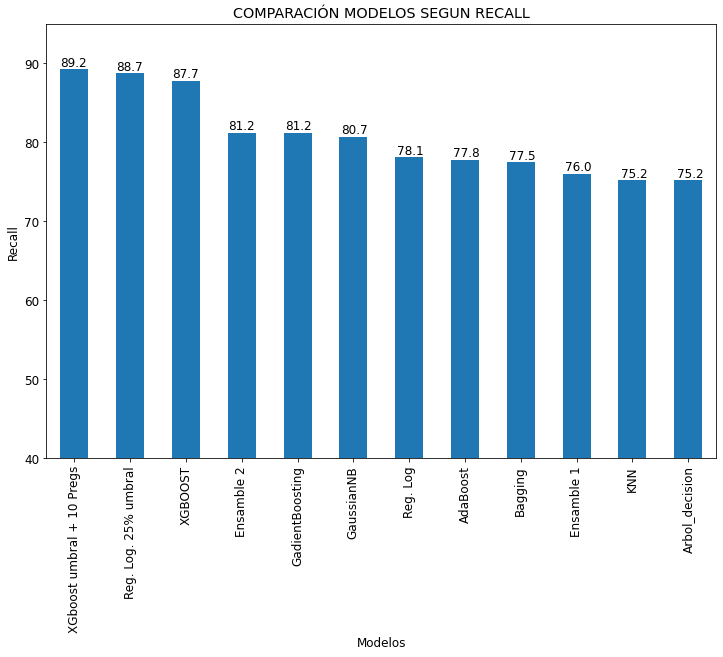

In [98]:
plotSuccess1()

In [99]:
def plotSuccess():
    s = pd.Series(methodDict)
    s = s.sort_values(ascending=False)
    plt.figure(figsize=(12,8))
    #Colors
    ax = s.plot(kind='bar') 
    for p in ax.patches:
        ax.annotate(str(round(p.get_height(),2)), (p.get_x() * 1.005, p.get_height() * 1.005))
    plt.ylim([65.0, 90.0])
    plt.xlabel('Modelos')
    plt.ylabel('Accuracy')
    plt.title('COMPARACIÓN MODELOS SEGUN ACCURACY')
     
    plt.show()

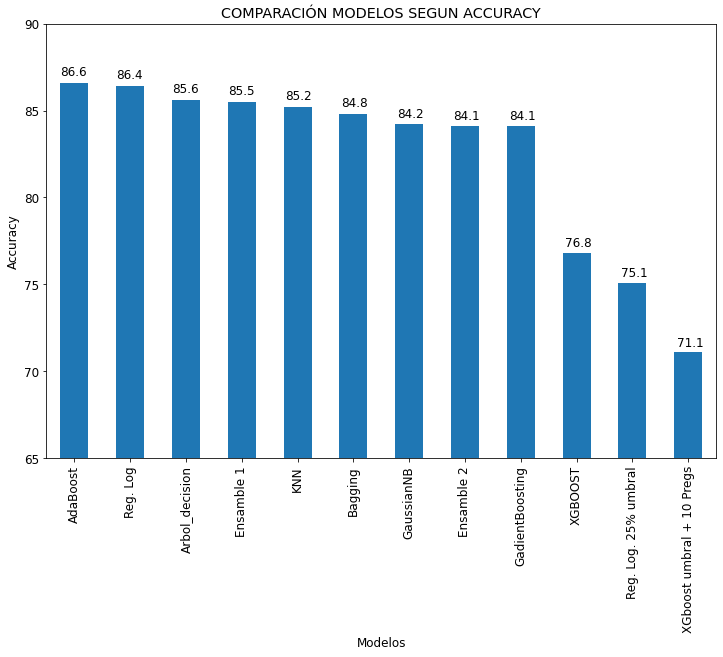

In [100]:
plotSuccess()

<a id="section_20"></a>

### Conclusión y serialización del mejor modelo ###

[volver a TOC](#section_toc)

Nuestro mejor modelo predictivo es XGBoost, debido a que el Recall es de 89.2 y realizando solamente 10 preguntas, que fueron resultado del Feature Importance de XGBoost. El objetivo de esta selección es buscar agilidad al momento de completar las preguntas por parte del profesional correspondiente. Por otro lado, elegimos este modelo ya que no requiere pre procesamiento adicional de datos. 

Cabe destacar que en todo momento priorizamos la medición del Recall ya que nuestro objetivo principal es detectar la mayor cantidad de los jóvenes que tienen una intención suicida para que reciban la ayuda correspondiente. Sabemos que tenemos como costo la reducción del Accuracy, pero al tener un objetivo tan sensible con un costo inicialmente bajo que debe ser manejado correctamente por el profesional, creemos que es conveniente hacerlo de esta manera.

Si vamos a un caso práctico y analítico de los resultados; de cada 10 jóvenes a los cuales un profesional somete a este cuestionario (suponiendo que tenemos la misma distribución de observaciones que en nuestros datos):

/- aproximadamente 6 serán predichos como "sin intención suicida" --> de estos 6 jóvenes, solo el 4% serán erróneamente predichos. Por lo que podemos tener una amplia tranquilidad en este 60% de resultados.

/- aproximadamente 4 serán predichos como "con intención suicida" --> de estos 4 jóvenes, la mitad tienen realmente una intención suicida y el profesional podrá profundizar con otros análisis adicionales.

Por lo antes dicho, podemos ver que se puede acotar muchísimo la base de pacientes a continuar con análisis adicionales y realizando solamente 10 preguntas. Por otro lado, podemos tener una confiabilidad del 96% que no estamos dejando fuera a un paciente con intención suicida.

Por lo tanto, se generara el archivo de serialización del mejor modelo entrenado.

In [101]:
import pickle
# Guardo el modelo de XGBoost
with open('model_xgboost.pkl', 'wb') as f_xgboost:
    pickle.dump(model_xgb, f_xgboost)

In [102]:
import os
# observamos si los archivos se crearon en la carpeta en donde estamos ejecutando la notebook
[x for x in os.listdir() if 'pkl' in x]

['model_xgboost.pkl']

In [103]:
#  Probamos levantar el modelo de XGBoost, y lo llamamos con otro nombre
with open('./model_xgboost.pkl', 'rb') as f_xgboost:
        modelo_xgboost = pickle.load(f_xgboost)

In [104]:
# Podemos ver que el modelo tiene guardado el atributo con los coeficientes, ya que lo guardamos ya entrenado
modelo_xgboost.best_params_

{'learning_rate': 0.1,
 'max_depth': 4,
 'n_estimators': 100,
 'scale_pos_weight': 10,
 'subsample': 0.8}